## Overflow CNN Workshop Food Dataset Data Augmentation Demo

In [1]:
from tensorflow import keras
print('keras: ', keras.__version__)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

keras:  2.2.4-tf


### Data Loading

For google colab. Make sure to change the path `/content/gdrive/My Drive/Food Dataset` based where you stored your folder in google drive (if you moved it). Note that trying to access the folder from "Shared with me" does not work so you will need to add a shortcut to `My Drive`.

[Colab Link](https://drive.google.com/drive/folders/1PL6LQfkSrxxrBHBfdHxnGDJTbJqiIAGU?usp=sharing)

In [2]:
#from google.colab import drive
#drive.mount("/content/gdrive")

In [3]:
#base_dir = '/content/gdrive/My Drive/Food Dataset'

For host system. Change the pathing accordingly.

[Local Machine Download](https://drive.google.com/file/d/1L0-Z5MQx5FewsCsOc6YQVl89OBqvQxvo/view?usp=sharing)

In [4]:
import os

base_dir = 'C:/Users/maste/Desktop/DL/Food Dataset'

Tensorflow will search for the 3 types of folders (`test`, `train` and `validation`) for use in data augmentation section later on.

In [5]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Building the First (Non-PreTrained) Model

Last layer activation is `softmax` since we are doing a multi-class, single label classification (sushi, baklava or cheesecake). 3 nodes are used on the last layer since there are 3 categories.

Convnets consists of (minimally):
* [Conv2D layer](https://keras.io/api/layers/convolution_layers/convolution2d/)
* [MaxPooling 2D layer](https://keras.io/api/layers/pooling_layers/max_pooling2d/)

Flatten layer is used to make the output from the final convnet 1 dimensional so that it can be passed into the dense layers.

In [6]:
from tensorflow.keras import layers, models, optimizers

# We set image size as 50*50.
img_size = 50

model = models.Sequential()
#padding: same--pad so that input size = output size, valid(default)--no padding
# 1st arg: no of filters
# 2nd arg: dimensionality of filters
model.add(layers.Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding = 'same',
                        input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4803      
Total params: 24,195
Trainable params: 24,195
Non-trainable params: 0
____________________________________________________

### Data Augmentation and Model Fitting

Data Augmentation does the following:

* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval

The first step is to compile the model with the `loss` (cannot be changed unless problem is binary classification), `optimizer` (can be changed) and `metrics` (what we are using to evaluate the model)

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Parameters in `ImageDataGenerator` can be changed according to your preference.

In [8]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True)

Now we can visualise the effects of data augmentation on our image in our codes below. To do this we basically sample an image from the datset and randomly transform it based on the parameters specified in `train_datagen`.

The codes below consist of an inline for-loop, also called a list comprehension. You can find out more about it using the link below.
* [list comprehension documentation](https://www.programiz.com/python-programming/list-comprehension)

Also included is the documentation the methods in the keras preprocessing library if you want to find out what possible arguments can be passed into these two methods.
* [keras preprocessing](https://keras.io/api/preprocessing/image/)

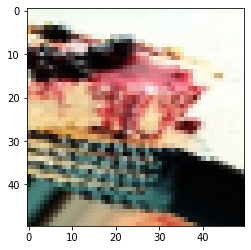

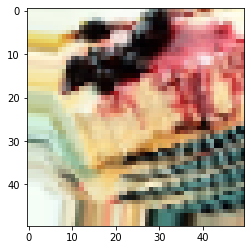

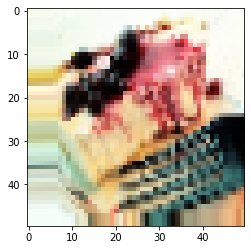

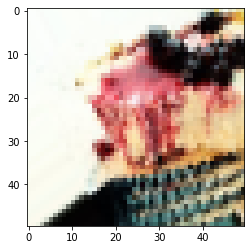

In [36]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

train_x_dir = os.path.join(base_dir, 'train/cheesecake')

#list comprehension: equivalent to a for loop, but faster and more efficient
fnames = [os.path.join(train_x_dir, file) for file in os.listdir(train_x_dir)]

# We pick one image to "augment"
img_path = fnames[0]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_size, img_size))

# Convert it to a Numpy array with shape (50, 50, 3)
x = image.img_to_array(img)

# Reshape it to (1, 50, 50, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
plt.show()

In [10]:
# All images will be rescaled by dividing the RGB value by 255
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 50x50
        target_size=(img_size, img_size),
        batch_size=45, 
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=12,
        class_mode='categorical')

Found 2250 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


**General Guidelines**
1. For training, `batch_size` * `steps_per_epoch` should be equal to number of images in `train` folder
2. For validation, `batch_size` * `validation_steps` should be equal to number of images in `validation` folder
3. For testing, `batch_size` * `steps` should be equal to number of images in `test` folder

so that there will only be `n` augmented samples where `n` is the number of training samples. So we will have 2250 regular, untransformed images and 2250 transformed images (expanded dataset).

**Fitting the model** (below)
* [`.fit` usage](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)

In [11]:
#stored in history to be used for plotting
history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=10, 
      validation_data=validation_generator,
      validation_steps= 50) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 50 steps
Epoch 1/10
50/50 [==============================] - 13s 256ms/step - loss: 1.0940 - acc: 0.3613 - val_loss: 1.0817 - val_acc: 0.4633
Epoch 2/10
50/50 [==============================] - 11s 226ms/step - loss: 1.0802 - acc: 0.4356 - val_loss: 1.0618 - val_acc: 0.5367
Epoch 3/10
50/50 [==============================] - 11s 223ms/step - loss: 1.0661 - acc: 0.4836 - val_loss: 1.0422 - val_acc: 0.5733
Epoch 4/10
50/50 [==============================] - 11s 227ms/step - loss: 1.0518 - acc: 0.5053 - val_loss: 1.0231 - val_acc: 0.5583
Epoch 5/10
50/50 [==============================] - 11s 228ms/step - loss: 1.0350 - acc: 0.5231 - val_loss: 1.0001 - val_acc: 0.6117
Epoch 6/10
50/50 [==============================] - 12s 235ms/step - loss: 1.0161 - acc: 0.5400 - val_loss: 0.9852 - val_acc: 0.5650
Epoch 7/10
50/50 [==============================] - 11s 227ms/step - loss: 0.9984 - acc: 0.5493 - val_loss: 0.

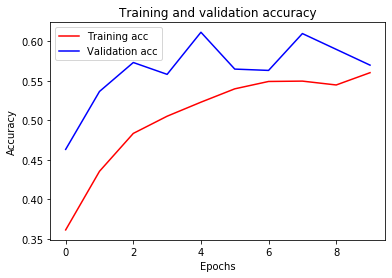

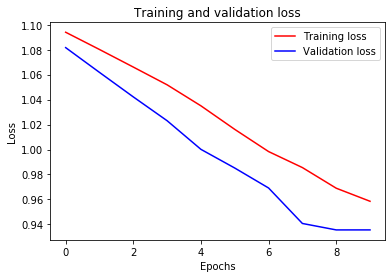

In [12]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
#evaluate
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=3,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50) 
print(f'test accuracy: {(test_acc * 100):.2f}%, test loss: {test_loss:.2f}')

Found 150 images belonging to 3 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
test accuracy: 54.67%, test loss: 0.94


In [14]:
model.save('nonpt_food_model.h5')

### Building the Second (Pre-Trained) Model

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

In our case, we use the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our food dataset, and then training a sushi vs baklava classifier on top of these features. Here's the [list of image classification models](https://keras.io/api/applications/) (all pre-trained on the ImageNet dataset) that are available as part of `tensorflow.keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet


In [15]:
from tensorflow.keras.applications import VGG16

img_size = 50

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

Like in the slides, `conv_base` is added before the flatten and dense layers.

In [16]:
from tensorflow.keras import layers, models, optimizers

# We set image size as 50*50.
img_size = 50

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))
conv_base.trainable = True

The set of codes below allow the layers weights from `block5_conv1` onwards to be trainable. Feel free to change this to one of the other layers of the VGG architecture above.

In [17]:
set_trainable = False

#unfreeze only layers starting from the specified layer
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True 
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 7,080,963
Non-trainable params: 7,635,264
_________________________________________________________________


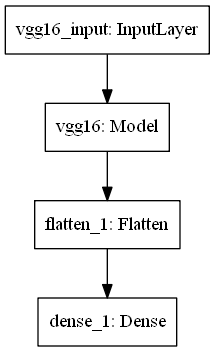

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model2.png')

In [19]:
#changed optimiser
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True)

# All images will be rescaled by dividing the RGB value by 255
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 50x50
        target_size=(img_size, img_size),
        batch_size=45, 
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=12,
        class_mode='categorical')

#stored in history to be used for plotting
history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=10, 
      validation_data=validation_generator,
      validation_steps= 50) 

Found 2250 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 50 steps
Epoch 1/10
50/50 [==============================] - 15s 297ms/step - loss: 0.8217 - acc: 0.6329 - val_loss: 0.6697 - val_acc: 0.7167
Epoch 2/10
50/50 [==============================] - 13s 260ms/step - loss: 0.6821 - acc: 0.7276 - val_loss: 0.6496 - val_acc: 0.7300
Epoch 3/10
50/50 [==============================] - 14s 272ms/step - loss: 0.6271 - acc: 0.7427 - val_loss: 0.6369 - val_acc: 0.7317
Epoch 4/10
50/50 [==============================] - 14s 274ms/step - loss: 0.5795 - acc: 0.7591 - val_loss: 0.5966 - val_acc: 0.7533
Epoch 5/10
50/50 [==============================] - 14s 271ms/step - loss: 0.5534 - acc: 0.7813 - val_loss: 0.6226 - val_acc: 0.7367
Epoch 6/10
50/50 [==============================] - 14s 281ms/step - loss: 0.5686 - acc: 0.7631 - val_loss: 0.5968 - val_acc: 0.7467
Epoch 7/10
50/50 [=========

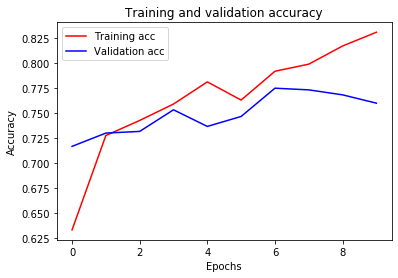

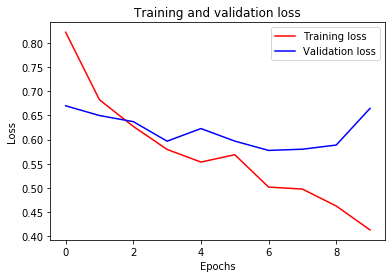

In [21]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
#evaluate
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=3,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50) 
print(f'test accuracy: {(test_acc * 100):.2f}%, test loss: {test_loss:.2f}')

Found 150 images belonging to 3 classes.
  ...
    to  
  ['...']
test accuracy: 72.00%, test loss: 0.68


In [23]:
model.save('pt_food_model.h5')

From the results, the pretrained model achieved a higher test accuracy as compared with the non-pretrained one.

### Evaluating both models on new data

In [24]:
# Load the model 
from tensorflow.keras import models
model = models.load_model('nonpt_food_model.h5')
food_list = ['baklava', 'cheesecake', 'sushi']

The `image_process` function does the normalization of the RGB values. The `prediction` function outputs a dataframe containing the probabilities of each food type and the corresponding label.

In [25]:
# Define some related functions for image process and model prediction
from keras.preprocessing.image import load_img, img_to_array
import pandas as pd

img_size = 50
def image_process(img, img_size):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

def prediction(model, img_array, items_l, img_size):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

Using TensorFlow backend.


Feel free to change the image according to the images in the Internet Test Images folder.

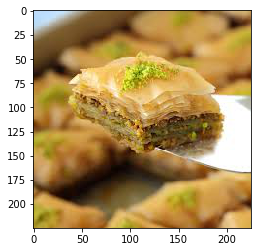

The prediction is:  baklava 

     baklava  cheesecake     sushi
0  0.496606    0.189922  0.313472


In [26]:
import matplotlib.pyplot as plt
import numpy as np
# the picture you downloaded from internet, which contains a type of food in your food list
img = 'Food Dataset/Internet Test Images/baklava.jpg' 
# img = '/content/gdrive/My Drive/Food Dataset/Internet Test Images/baklava.jpg' 
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img, img_size)

prob_df, result = prediction(model, img_array, food_list, img_size)
print('The prediction is: ', result, '\n\n', prob_df)

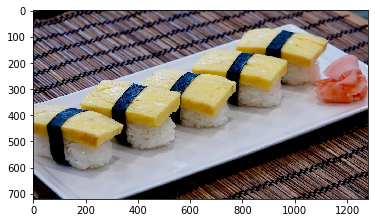

The prediction is:  sushi 

     baklava  cheesecake     sushi
0  0.088143     0.26136  0.650496


In [27]:
import matplotlib.pyplot as plt
import numpy as np
# the picture you downloaded from internet, which contains a type of food in your food list
img = 'Food Dataset/Internet Test Images/sushi3.jpg' 
# img = '/content/gdrive/My Drive/Food Dataset/Internet Test Images/baklava.jpg' 
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img, img_size)

prob_df, result = prediction(model, img_array, food_list, img_size)
print('The prediction is: ', result, '\n\n', prob_df)

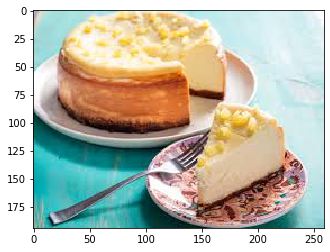

The prediction is:  baklava 

     baklava  cheesecake     sushi
0  0.414472      0.2596  0.325928


In [28]:
import matplotlib.pyplot as plt
import numpy as np
# the picture you downloaded from internet, which contains a type of food in your food list
img = 'Food Dataset/Internet Test Images/cheesecake3.jpg' 
# img = '/content/gdrive/My Drive/Food Dataset/Internet Test Images/baklava.jpg' 
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img, img_size)

prob_df, result = prediction(model, img_array, food_list, img_size)
print('The prediction is: ', result, '\n\n', prob_df)

### Activity: Building a third model yourself! (replicate as necessary)
Now it's your turn to try to build a model by yourself. You can choose either to use the pretrain or non-pretrained architectures. You may play around with the following hyperparameters:

* layers (add/remove layers)
* nodes (add/remove nodes)
* unfreeze more layers 
* change optimizer (Adam, RMSprop, SGD, Adagrad etc.) and learning rate (1e-3, 5e-4 etc.)
* change data augmentation parameters
* change batch size (remember to change steps accordingly)
* run for more/fewer epochs
* use a different `img_size`
* add [dropout](https://keras.io/api/layers/regularization_layers/dropout/) and/or regularization
* use another type of pretrained architecture
* add/remove padding and strides (play around with dimensionality)

In [29]:
# Build the model

In [30]:
# Compile the Model

In [31]:
# Data Augmentation--train/validation generator

In [32]:
# Model fitting --use model.fit()

In [33]:
# Training and Validation Accuracy Plots using matplotlib

In [34]:
# Model evaluation using test data

In [35]:
# Model evaluation using Internet Test Images